# A Framework for Deep Convolutional Neural Networks for the Binary Classification of Time Series
In this notebook I construct a framework for deep convolutional neural networks aimed at the binary classification of time series. The data I used to test models was series of heartbeat intervals of varying length along with the subject's self recorded happy/sad state (1 / 0). The data had been zero padded so all series were the same length, and also normalised between zero and one (a requirement for neural networks).

### Imports
Below are the imports required to run this notebook. Some general housekeeping (display options, ignoring a redundant warning) is done and useful modules are imported. This framework uses PyTorch (torch) to build models and SKORCH (skorch) to wrap the models, allowing the use of some scikit-learn (sklearn) functionality. SKORCH also allows the use of callbacks which are an extremely flexible way of adding functions during training, like logging performance metrics to experiment tracking websites like Weights and Biases (wandb).

In [7]:
# General
import sys
import warnings
warnings.filterwarnings("ignore", message = "The epoch parameter")
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from datetime import datetime

# Pickle for saving and loading models
import pickle

# Data structures and maths
from collections import OrderedDict
import random
import numpy as np
np.set_printoptions(precision = 3, floatmode = 'fixed', suppress = True)
import pandas as pd
pd.set_option('display.max_columns', None)

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import swa_utils
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn
from torch.utils.data import TensorDataset, Subset

#
!{sys.executable} -m pip install torch_optimizer
from torch_optimizer import Ranger

# SKORCH and Weights and Biases
import wandb
from sklearn.metrics import accuracy_score, confusion_matrix
from skorch import NeuralNetBinaryClassifier
from skorch.helper import predefined_split
from skorch.callbacks import Callback, LRScheduler, WarmRestartLR, Checkpoint, EpochScoring, WandbLogger

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Loading the Data
The data is loaded using pickle, a convenient way to save python objects for later use. However, pickle cannot save objects containing lambda functions so they are avoided here.  
The data is a series of time series labelled as either 0 or 1. The time series were originally of different lengths so they have been zero padded, the data has also been normalised. This preprocessing was done outside of this notebook as the data is only here to demonstrate the use of this model framework.

In [8]:
# Load the data object by using pickle to unserialise the '.pkl' file
with open('padded_normalised_data.pickle', 'rb') as handle:
    
    data = pickle.load(handle)

### Final Data Preparation
In this cell the data is separated into its predetermined training and testing portions, converted to a consistent data type and assembled into torch datasets. The dimensions of each set are printed as a sanity check. There are 273 (80%) records in the train set and 69 (20%) in the test set. Each record is a time series of length 556, the labels are binary values of 0 or 1.

In [9]:
# Prepare the data for use with PyTorch
train_inputs = np.array(data['X_train']).astype(np.float32)
print(train_inputs.shape)
train_labels = np.array(data['Y_train']).astype(np.float32)
print(train_labels.shape)
test_inputs = np.array(data['X_test']).astype(np.float32)
print(test_inputs.shape)
test_labels = np.array(data['Y_test']).astype(np.float32)
print(test_labels.shape)

train_dataset = TensorDataset(torch.from_numpy(train_inputs), torch.from_numpy(train_labels))
valid_dataset = TensorDataset(torch.from_numpy(test_inputs), torch.from_numpy(test_labels))

(273, 556)
(273,)
(69, 556)
(69,)


### Model Framework
Explain choices

In [10]:
#################################################### Network Class ########################################################

# Building a flexible Temporal Convolutional Network (TCN) classifier
# Variable depth, number of filters and dropout probability
class Net(nn.Module):
    
    def __init__(self, 
                 an_input = train_inputs[0], 
                 batch = 1, 
                 conv_layers = 4, 
                 num_filters = 16, 
                 dropout_prob = 0.1, 
                 reg_l1 = 0.01, 
                 swa_start_frac = 0.75):
        
        super(Net, self).__init__()
        
        # Network hyperparameters
        self.batch_size = batch       # Number of series in each batch
        self.n_convs = conv_layers    # Number of convolutional layers
        self.n_filters = num_filters  # Number of filters in each convolutional layer
        self.dropout_p = dropout_prob # Probability of each weight being zeroed in each dropout layer
        self.example_inp = an_input   # Takes a series from the training set to use for shape reference
        self.lambda1 = reg_l1         # Strength of L1 regularisation penalty
        
        # Get input shape from a training sample
        self.sample_len = max(np.shape(self.example_inp))
        self.dat_chans = self.example_inp.shape[-2] if len(self.example_inp.shape) > 1 else 1 # Number of channels in input
        self.input_shape = (self.batch_size, self.dat_chans, self.sample_len)
        ##print('Input shape: {}\n'.format(self.input_shape))
        
        # Activation function
        #activation = nn.ReLU()
        activation = nn.LeakyReLU(0.01)
        #activation = nn.PReLU()

        # List of kernel sizes (number of times-teps covered) for each convolutional layer
        kernel_sizes = [2] + [4 + (2 * i) for i in range(self.n_convs - 1)]

        # The list is reversed so the layers look for longer features first, then shorter, down to 2 samples wide
        kernel_sizes = kernel_sizes[::-1]

        # First layer
        layers = [('conv1', nn.Conv1d(in_channels = self.dat_chans, 
                                      out_channels = self.n_filters, 
                                      kernel_size = kernel_sizes[0])), 
                  ('relu1', activation), 
                  ('norm1', smart_batch_norm(self.n_filters)), #nn.BatchNorm1d(self.n_filters)), 
                  ('drop1', nn.Dropout(self.dropout_p, inplace = True))]

        # Initialise a list for the length of the output of each convolution
        # Value is initialised based on input length for use in recursive formula: L_out = (L_in - kernal_size) + 1
        conv_out_len = (self.input_shape[2] - kernel_sizes[0]) + 1
        conv_out_shapes = [(self.batch_size, self.n_filters, conv_out_len)]

        ##print('Convolution: {}\nOutput shape: {}\n'.format(1, conv_out_shapes[0]))

        # Intermediate convolutional layers
        for conv_n in range(2, self.n_convs + 1):
            
            conv_out_len = (conv_out_len - kernel_sizes[conv_n - 1]) + 1
            conv_out_shapes.append((self.batch_size, self.n_filters, conv_out_len))
            ##print('Convolution: {}\nOutput shape: {}\n'.format(conv_n, conv_out_shapes[conv_n - 1]))

            layers.append(('conv{}'.format(conv_n), nn.Conv1d(in_channels = self.n_filters, 
                                                              out_channels = self.n_filters, 
                                                              kernel_size = kernel_sizes[conv_n - 1])))

            layers.append(('relu{}'.format(conv_n), activation))
            layers.append(('norm{}'.format(conv_n), smart_batch_norm(self.n_filters)))
            layers.append(('drop{}'.format(conv_n), nn.Dropout(self.dropout_p, inplace = True)))
            
            # Final convolution needs some reshaping to fit the densely connected output layer
            if conv_n == (self.n_convs):

                layers.append(('gpool', nn.AvgPool1d(conv_out_len)))
                layers.append(('shape', shaper()))

        # Linear output layer
        layers.append(('dense', nn.Linear(in_features = self.n_filters, 
                                          out_features = 1)))
        
        layers.append(('normo', smart_batch_norm(1))) #nn.BatchNorm1d(1)

        layers_dict = OrderedDict(layers)
        
        # Initialise the weights, sampling from a normal Kaiming He distribution
        for conv_n in range(self.n_convs):
            
            #print(layers_dict['conv' + str(conv_n + 1)])
            torch.nn.init.kaiming_normal_(layers_dict['conv' + str(conv_n + 1)].weight, 
                                          a = 0.01, 
                                          nonlinearity = 'leaky_relu')
        
        torch.nn.init.kaiming_normal_(layers_dict['dense'].weight, 
                                      a = 0.01, 
                                      nonlinearity = 'leaky_relu')
        
        # Construct the network
        self.net = nn.Sequential(layers_dict)
    
    # Infer and reshape input then pass through network
    def forward(self, x):
        
        self.batch_size = x.shape[0] if len(x.shape) > 1 else self.batch_size
        x = x.view(self.batch_size, self.dat_chans, self.sample_len)
        
        return self.net(x)
    
    # Applying L1 Regularisation to the network activations by overriding SKORCH's 'get_loss()'
    # This encourages the network to keep only meaningful weights by penalising the loss based on the sum of weights
    def get_loss(self, y_pred, y_true, X = None, training = False):

        # Grab the loss from just the criterion
        loss = super().get_loss(y_pred, y_true, X = X, training = training)

        # Add on the sum of all the model weights, multiplied by the L1 coefficient (penalty strength)
        loss += self.lambda1 * sum([w.abs().sum() for w in net.module_.parameters()
                                    if len(w.shape) > 1]) # Avoids the biases as these are not typically included

        return loss

################################################### Custom Modules ########################################################

# Custom module to flatten outputs, that is useable in nn.Sequential()
class shaper(nn.Module):
    
    def forward(self, x):
        
        return x.view(-1, x.shape[1])

# Adapted version of PyTorch's 'BatchNorm1d' class, that will ignore 'batches' with only one sample
class smart_batch_norm(nn.BatchNorm1d):
    
    # Overwrite the 'forward' method
    def forward(self, x):
        
        self._check_input_dim(x)
        
        if self.momentum is None:
            
            exponential_average_factor = 0.0
            
        else:
            
            exponential_average_factor = self.momentum

        if self.training and self.track_running_stats:
            
            if self.num_batches_tracked is not None:
                
                self.num_batches_tracked = self.num_batches_tracked + 1
                
                if self.momentum is None:
                    
                    exponential_average_factor = 1.0 / float(self.num_batches_tracked)
                    
                else:
                    
                    exponential_average_factor = self.momentum
        
        if self.training:
            
            bn_training = True
        
        else:
            
            bn_training = (self.running_mean is None) and (self.running_var is None)
        
        # This section was added
        if x.shape[0] == 1:
            
            return_output = x
        
        else:
            
            return_output = F.batch_norm(x, self.running_mean if not self.training or self.track_running_stats else None, 
                                         self.running_var if not self.training or self.track_running_stats else None, 
                                         self.weight, 
                                         self.bias, 
                                         bn_training, 
                                         exponential_average_factor, 
                                         self.eps)
        
        return return_output

# A SKORCH callback to implement Stochastic Weight Averaging (SWA)
# Developed with Benjamin Bossan (https://github.com/BenjaminBossan)
class StochasticWeightAveraging(Callback):
    
    def __init__(self,
                 swa_utils,
                 swa_start_frac = 0.75,
                 verbose = 0,
                 sink = print,
                 **kwargs):  # additional arguments to swa_utils.SWALR
        
        self.swa_utils = swa_utils
        self.swa_start_frac = swa_start_frac
        self.verbose = verbose
        self.sink = sink
        vars(self).update(kwargs)

    @property
    def kwargs(self):
        
        # These are the parameters that are passed to SWALR.
        # Parameters that don't belong there must be excluded.
        excluded = {'swa_utils', 'swa_start_frac', 'verbose', 'sink'}
        kwargs = {key: val for key, val in vars(self).items()
                  if not (key in excluded or key.endswith('_'))}
        
        return kwargs

    def on_train_begin(self, net, **kwargs):
        
        self.optimizer_swa_ = self.swa_utils.SWALR(net.optimizer_, 
                                                   anneal_epochs = max([1, round(net.max_epochs / 100)]), 
                                                   **self.kwargs)
        
        if not hasattr(net, 'module_swa_'):
            
            net.module_swa_ = self.swa_utils.AveragedModel(net.module_)
            
    def on_epoch_begin(self, net, **kwargs):
        
        if self.verbose and len(net.history) == round(self.swa_start_frac * net.max_epochs) + 1:
            
            self.sink("Using SWA to update parameters")

    def on_epoch_end(self, net, **kwargs):
        
        if len(net.history) > round(self.swa_start_frac * net.max_epochs):
            
            net.module_swa_.update_parameters(net.module_)
            self.optimizer_swa_.step()
            current_lr = net.callbacks[3].optimizer_swa_.get_last_lr()[0]
            net.lr_history[-1] = current_lr
            
        net.history.record('lr', net.lr_history[-1])

    def on_train_end(self, net, X, y = None, **kwargs):
        
        if self.verbose:
            
            self.sink("Using training data to update batch norm statistics of the SWA model")

        loader = net.get_iterator(net.get_dataset(X, y))
        self.swa_utils.update_bn(loader, net.module_swa_, device = net.device)

class WarmRestartLR_with_log(WarmRestartLR):
    
    def _get_current_lr(self, min_lr, max_lr, period, epoch):
        
        lr = min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos((epoch * np.pi) / period))
        net.lr_history.append(lr)
        
        return lr

class LRScheduler_with_log(LRScheduler):
    
    def _get_policy_cls(self):
        
        if isinstance(self.policy, str):
            
            if self.policy == 'WarmRestartLR_with_log':
                
                return WarmRestartLR_with_log
            
            else:
                
                return getattr(sys.modules[__name__], self.policy)
        
        return self.policy

################################################# Training Functions ######################################################

# Plot loss and validation accuracy curves for a trained network
def train_curves(network):
    # Get data for training curve plots
    epoch_losses = np.array(network.history[:, 'train_loss'])
    epoch_val_accs = np.array(network.history[:, 'valid_acc'])
    epoch_ns = np.arange(len(epoch_losses))

    # Construct the plots
    sns.lineplot(epoch_ns, epoch_losses, color = "g", label = 'Training Loss')
    plt.ylim(0, 1)
    plt.gca().get_legend().set_visible(False)
    plt.xlabel('Training Epoch')
    plt.ylabel('Training Loss')
    lines, labels = plt.gca().get_legend_handles_labels()
    ax2 = plt.twinx()
    ax2.set_ylabel('Validation Accuracy %')
    ax2.plot(epoch_ns, (100 * epoch_val_accs), color = "m", label = 'Validation Accuracy')
    ax2.set_ylim(40, 100)
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.title('Model Training Curves')
    ax2.legend(lines + lines2, labels + labels2, loc = 'best')
    plt.show()

#################################################### SKORCH Wrapper #######################################################

# Function to simplify creating networks, it just serves to hide some arguments that I won't change and offer defaults
def constructor(num_filters = 128, 
              conv_layers = 4, 
              dropout_prob = 0.5, 
              reg_l1 = 0.01, 
              epochs = 100, 
              start_lr = 0.1, 
              batch = 128, 
              opt = 'Ranger', 
              swa_start_frac = 0.75, 
              swa_lr = 0.05, 
              cos_restarts = 5, 
              cos_t_mult = 1, 
              dev = 'cuda', 
              wandb = True):
    
    opts = {'SGD': optim.SGD, 
            'Adam': optim.Adam, 
            'Adadelta': optim.Adadelta, 
            'Ranger': Ranger}
    
    opt_str = opt
    
    opt = opts[opt_str]
    
    # List of callbacks that happen within the training loop
    cbs = [LRScheduler_with_log(policy = 'WarmRestartLR_with_log', 
                                min_lr = 1e-4, 
                                max_lr = start_lr, 
                                base_period = round(epochs / cos_restarts), 
                                period_mult = cos_t_mult), 
           EpochScoring(scoring = 'accuracy', 
                        lower_is_better = False, 
                        on_train = True), 
           WandbLogger(wandb_run = wandb_run) if wandb else None, 
           StochasticWeightAveraging(swa_utils, swa_start_frac, verbose = 1, swa_lr = swa_lr)]
    
    # Feed all the parameters to the SKORCH wrapper class, allowing us to blend pytorch models with sklearn functionality
    net = NeuralNetBinaryClassifier(module = Net, module__num_filters = num_filters, module__conv_layers = conv_layers, 
                                    module__dropout_prob = dropout_prob, module__reg_l1 = reg_l1, max_epochs = epochs, 
                                    lr = start_lr, batch_size = batch, criterion = nn.BCEWithLogitsLoss, 
                                    optimizer = opt, module__swa_start_frac = swa_start_frac, 
                                    train_split = predefined_split(valid_dataset), device = dev, callbacks = cbs)
    
    net.relevant_hparams = dict(num_filters = num_filters, 
                                conv_layers = conv_layers, 
                                dropout_prob = dropout_prob, 
                                reg_l1 = reg_l1, 
                                epochs = epochs, 
                                start_lr = start_lr, 
                                batch = batch, 
                                opt = opt_str, 
                                swa_start_frac = swa_start_frac, 
                                swa_lr = swa_lr, 
                                cos_restarts = cos_restarts, 
                                cos_t_mult = cos_t_mult, 
                                dev = dev)
    
    net.lr_history = []
    
    return net

##################################################### Validation ##########################################################

# Evaluates a network on the test set
def evaluate(network):
    
    # Prevents PyTorch from accumulating gradients for any operations performed here
    with torch.no_grad(): 
    
        # Get accuracy and confusion matrix using 'sklearn.metrics'
        percent_accuracy = round(accuracy_score(valid_dataset[:][1], network.predict(valid_dataset[:][0])) * 100, 1)
        print('Percentage accuracy on test dataset: {}%'.format(percent_accuracy))

        conf_mat = confusion_matrix(valid_dataset[:][1], network.predict(valid_dataset[:][0]))

        # Display the confusion matrix using Seaborn's heatmap
        sns.heatmap(conf_mat, cmap = 'Greens', annot = True, fmt = '.0f', cbar = False)
        plt.xlabel('Predicted Value')
        plt.ylabel('True Value')
        plt.title('Confusion Matrix for Temporal Convolutional Network Model')
        plt.show()
    
    return percent_accuracy

# Fits a model and reports it's training curves, confusion matrix and accuracy
def train_and_eval(network):
    
    t0 = datetime.now()
    print('Started: {}'.format(t0))
    
    network.fit(train_dataset[:][0], train_dataset[:][1])
    train_curves(network)
    evaluate(network)
    
    t1 = datetime.now()
    print('Finished: {}'.format(t1))
    delta_t = str(t1 - t0)
    print('Time taken: {}h {}m {}s {}ms'.format(delta_t[:-13], delta_t[-12:-10], delta_t[-9:-7], delta_t[-6:-3]))

####################################################### Tuning ############################################################

# Manual random search n-fold cross validation
def param_search(params, n_fits = 10, k_folds = 3, verb = 0):

    # Find set lengths and an index for the whole dataset
    test_len = int(train_dataset.__len__() / k_folds)
    train_len = train_dataset.__len__() - test_len
    idx = [i for i in range(train_dataset.__len__())]

    # Use the baseline model (most abundant class) as a benchmark to beat
    test_accs = [base_train_acc]
    best_params = {'Best Model': ('Baseline', 'Accuracy = {:.3g}%'.format(test_accs[0] * 100)), 
                   'Best Params': 'Failed to beat baseline'}
    
    param_df_rows = []

    # Time the whole parameter search
    t0 = datetime.now()
    print('Parameter search started: {}\n'.format(t0))

    # Loop to produce 'n_fits' different models, each one is fitted and evaluated on 'n_folds' for an average accuracy
    for fit_n in range(n_fits):
        
        # Time each model
        t1 = datetime.now()
        print('Model {} of {} started: {}'.format(fit_n + 1, n_fits, t0))

        these_params = {}
        param_df_rows.append(these_params)

        # Grab a random value from the list for each parameter in the params dictionary
        for param in params:

            rand_idx = np.random.randint(len(params[param]))
            this_param = params[param][rand_idx]
            these_params[param] = this_param

        # Create a model with these parameters
        this_model = constructor(**these_params)
        print('Params: {}'.format(these_params))
        this_model.set_params(verbose = verb)

        used_idx = []
        fold_accs = []
        
        # Folds
        for fold_k in range(k_folds):

            print('Fitting fold {} of {}...'.format(fold_k + 1, k_folds))

            # Get a unique test subsection of the dataset for the current fold
            unused_idx = list(np.setdiff1d(idx, used_idx))
            test_idx = random.sample(unused_idx, test_len)
            used_idx += list(test_idx)

            # Get the corresponding train section
            train_idx = np.setdiff1d(idx, test_idx)

            # Index the dataset
            train_set = Subset(train_dataset, train_idx)
            test_set = Subset(train_dataset, test_idx)

            # Fit and evaluate the model for this fold
            this_model.fit(train_set[:][0], train_set[:][1])
            fold_acc = accuracy_score(test_set[:][1], this_model.predict(test_set[:][0]))
            fold_accs.append(fold_acc)

        # Find the average performance of the folds
        test_acc = np.mean(fold_accs)
        test_accs.append(test_acc)

        # Show training curves for the last fold
        #train_curves(this_model)
        
        # Get end time and duration
        t2 = datetime.now()
        print('Model finished: {}'.format(t1))
        delta_t = str(t2 - t1)
        print('Time taken: {}h {}m {}s {}ms\n'.format(delta_t[:-13], delta_t[-12:-10], delta_t[-9:-7], delta_t[-6:-3]))
        print('Average accuracy on test dataset: {:.3g}%\n\n'.format(test_acc * 100))

        # Update the current best parameters
        if test_acc >= max(test_accs):

            best_params['Best Model'] = ('Model {}'.format(fit_n), 'Accuracy = {:.3g}%'.format(test_acc * 100))
            best_params['Best Params'] = these_params
    
    # Get end time and duration of whole parameter search
    t3 = datetime.now()
    print('\n\nParameter search finished: {}'.format(t1))
    delta_t = str(t3 - t0)
    print('Total time taken: {}h {}m {}s {}ms'.format(delta_t[:-13], delta_t[-12:-10], delta_t[-9:-7], delta_t[-6:-3]))
    
    param_df = pd.DataFrame(param_df_rows, index = ['model_' + str(i + 1) for i in range(n_fits)])
    param_df['test_accuracy'] = test_accs[1:]
    param_df.sort_values('test_accuracy', inplace = True, ascending = False)
    
    return best_params, param_df

####################################################### Utility ###########################################################

def save_model(net, name):

    with open(name + '.pickle', 'wb') as handle:

        pickle.dump((net.relevant_hparams, net.module_.state_dict()), handle, protocol = pickle.HIGHEST_PROTOCOL)
        
def load_model(pkl):
    
    with open(pkl, 'rb') as handle:
    
        hparams, state_dict = pickle.load(handle)
    
    model = constructor(**hparams, wandb = False)

    model.initialize()
    model.module_.load_state_dict(state_dict, strict = False)
    
    return model

def now_str():
    
    now = str(datetime.now())
    year = now[:4]
    month = now[5:7]
    day = now[8:10]
    time = now[11:19]
    
    return '{}_{}_{}__{}'.format(year, month, day, time)

############################################ IN PROGRESS... 




### Loading and Evaluating an Existing Model
Here's one I made earlier.

Percentage accuracy on test dataset: 68.1%


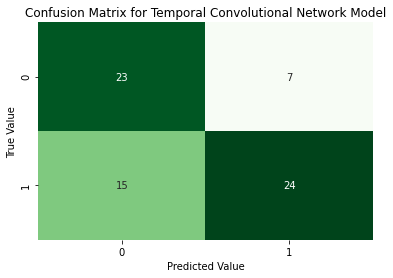

In [11]:
# Loading and evaluating
swa_68 = load_model('model_params_68.pickle')
swa_acc = evaluate(swa_68)

### Producing and Training Models

Started: 2020-12-15 21:56:38.934062
  epoch    accuracy      lr    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------  ------------  -----------  ------------  ------
      1      0.4872  0.1000        0.8070       0.4348     4230.4878  0.9583
      2      0.5568  0.0991        0.7314       0.4348      509.6132  0.3481
      3      0.5751  0.0966        0.7107       0.4348      148.3356  0.3491
      4      0.5897  0.0925        0.7009       0.4348       64.1563  0.3396
      5      0.5861  0.0870        0.6940       0.4348       33.2402  0.3391
      6      0.5861  0.0802        0.6880       0.4348       18.9555  0.3453
      7      0.5714  0.0723        0.6848       0.4348       11.5124  0.3426
      8      0.5714  0.0637        0.6828       0.4348        7.3288  0.3415
      9      0.5678  0.0547        0.6812       0.4348        4.8921  0.3461
     10      0.5678  0.0454        0.6811       0.4348        3.4010  0.3417
     11      0.5934  0.0364        0.680

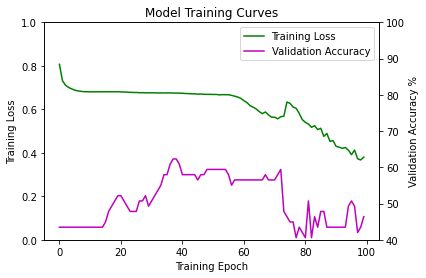

Percentage accuracy on test dataset: 46.4%


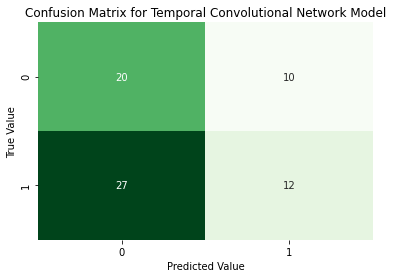

Finished: 2020-12-15 21:57:16.501546
Time taken: 0h 00m 37s 567ms


Generating and evaluating SWA model: 
Percentage accuracy on test dataset: 58.0%


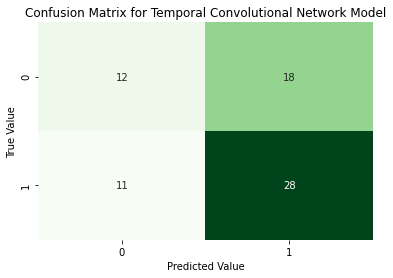

In [14]:
hyperparameters = dict(num_filters = 128, 
                       conv_layers = 4, 
                       dropout_prob = 0.1, 
                       reg_l1 = 0.001, 
                       epochs = 100, 
                       start_lr = 0.1, 
                       batch = 273, 
                       opt = 'Adam', 
                       swa_start_frac = 0.75, 
                       swa_lr = 0.05, 
                       cos_restarts = 6, 
                       cos_t_mult = 1)

#wandb_run = wandb.init(project = "DeepCNNTimeSeriesClassifier", 
#                       reinit = True, 
#                       name = now_str(), 
#                       notes = 'None')

net = constructor(**hyperparameters)
#wandb.config.update(net.relevant_hparams)

train_and_eval(net)

#wandb_run.join()

print('\n\nGenerating and evaluating SWA model: ')
swa_net = NeuralNetBinaryClassifier(module = net.module_swa_, 
                                    train_split = predefined_split(valid_dataset), 
                                    device = 'cuda')

swa_net.initialize()

swa_acc = evaluate(swa_net)

torch.cuda.empty_cache()

### Saving a Model
This will save a copy of the above model, just as a demonstration.

In [6]:
# Saving
save_model(swa_68, 'model_params_68_copy')

### Data Augmentation
To be continued...
https://arxiv.org/pdf/2002.12478.pdf

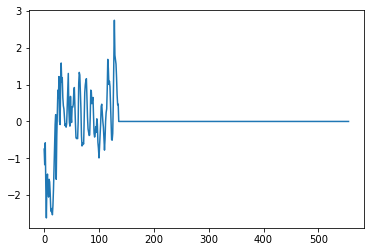

In [16]:
sns.lineplot(data = train_inputs[0])